In [1]:
import pandas as pd
import requests
import random
import time
import matplotlib.pyplot as plt

In [2]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0",
    "Accept-Language": 'en-US,en;q=0.9',
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Referer": "https://tiki.vn/",
    "From": "",
    "af-ac-enc-dat": "",
    "x-api-source": "pc"
}

### EXTRACT SUB CATEGORY

In [ ]:
URL = "https://api.tiki.vn/raiden/v2/menu-config?platform=desktop"
response = requests.get(URL, headers=HEADERS)
time.sleep(random.uniform(3.2, 8.7))
if response.status_code == 200:
    data = response.json()
else:
    print("Failed to fetch data:", response.status_code)
    
group = data["menu_block"]["items"]
group_list = []
for group in group:
    link = group["link"]
    group_id = link.split("/")[-1][1:]
    text = group["text"]
    
    if group_id in ["1846", "1789"]:
        group_list.append([group_id, text])

group = pd.DataFrame(group_list, columns=["GroupID", "Name"])

In [ ]:
category_list = []
for group_id, group_name in zip(group["GroupID"], group["Name"]):
    parent_url = f"https://tiki.vn/api/v2/categories?parent_id={group_id}"
    parent_response = requests.get(parent_url, headers=HEADERS)
    time.sleep(random.uniform(3.2, 8.7))
    if parent_response.status_code == 200:
        parent_data = parent_response.json()
        if not parent_data["data"]:
            category_list.append([group_id, group_name, None, None, None, None, None, None])
        else:
            for parent_category in parent_data["data"]:
                parent_id = parent_category["id"]
                parent_name = parent_category["name"]
                
                child_url = f"https://tiki.vn/api/v2/categories?parent_id={parent_id}"
                child_response = requests.get(child_url, headers=HEADERS)
                time.sleep(random.uniform(3.2, 8.7))
                
                if child_response.status_code == 200:
                    child_data = child_response.json()
                    if not child_data["data"]:
                        category_list.append([group_id, group_name, parent_id, parent_name, None, None, None, None])
                    else:
                        for child_category in child_data["data"]:
                            child_id = child_category["id"]
                            child_name = child_category["name"]
                            
                            type_url = f"https://tiki.vn/api/v2/categories?parent_id={child_id}"
                            type_response = requests.get(type_url, headers=HEADERS)
                            time.sleep(random.uniform(3.2, 8.7))
                            
                            if type_response.status_code == 200:
                                type_data = type_response.json()
                                if type_data["data"]:
                                    for type_item in type_data["data"]:
                                        type_id = type_item.get("id")
                                        type_name = type_item.get("name")
                                        category_list.append([group_id, group_name, parent_id, parent_name, child_id, child_name, type_id, type_name])
                                else:
                                    category_list.append([group_id, group_name, parent_id, parent_name, child_id, child_name, None, None])

category_df = pd.DataFrame(category_list, columns=["GroupID", "GroupName", "MasterCategoryID", "MasterCategoryName", "CategoryID", "CategoryName", "SubCategoryID", "SubCategoryName"])

In [ ]:
def remove_single_category(df):
    # Group the DataFrame by MasterCategoryID and count the unique CategoryID values
    category_counts = df.groupby('MasterCategoryID')['CategoryID'].nunique()
    
    # Create a mask for MasterCategoryIDs with only one CategoryID
    single_category_mask = category_counts == 1
    
    # Drop the CategoryID and CategoryName columns for rows where there is only one CategoryID
    df.loc[df['MasterCategoryID'].isin(single_category_mask[single_category_mask].index), ['CategoryID', 'CategoryName']] = [None, None]
    
    return df
  
cleaned_df = remove_single_category(category_df)

def transform_category(row):
    # Handle MasterCategory and Category
    if pd.isna(row['CategoryID']):
        master_category_id = row['MasterCategoryID']
        master_category_name = row['MasterCategoryName']
        category_id = row['MasterCategoryID']
        category_name = row['MasterCategoryName']
        is_category = 0
    else:
        master_category_id = row['MasterCategoryID']
        master_category_name = row['MasterCategoryName']
        category_id = row['CategoryID']
        category_name = row['CategoryName']
        is_category = 1

    # Handle SubCategory
    if pd.isna(row['SubCategoryID']):
        sub_category_id = category_id
        sub_category_name = category_name
        is_sub_category = 0
    else:
        sub_category_id = row['SubCategoryID']
        sub_category_name = row['SubCategoryName']
        is_sub_category = 1

    return pd.Series([
        master_category_id, master_category_name, category_id, category_name,
        is_category, sub_category_id, sub_category_name, is_sub_category
    ])
    
category_df[['MasterCategoryID', 'MasterCategoryName', 'CategoryID', 'CategoryName',
             'isCategory', 'SubCategoryID', 'SubCategoryName', 'isSubCategory']] = category_df.apply(transform_category, axis=1, result_type='expand')

In [ ]:
category_df["GroupID"] = category_df["GroupID"].astype(int)
category_df["MasterCategoryID"] = category_df["MasterCategoryID"].astype(int)
category_df["CategoryID"] = category_df["CategoryID"].astype(int)
category_df["SubCategoryID"] = category_df["SubCategoryID"].astype(int)


master_category = category_df[["MasterCategoryID", "GroupID", "MasterCategoryName"]].drop_duplicates()
master_category = master_category.rename(columns={"MasterCategoryName": "Name"})

category = category_df[["CategoryID", "MasterCategoryID", "CategoryName", "isCategory"]].drop_duplicates()
category = category.rename(columns={"CategoryName": "Name"})

sub_category = category_df[["SubCategoryID", "CategoryID", "SubCategoryName", "isSubCategory"]].drop_duplicates()
sub_category = sub_category.rename(columns={"SubCategoryName": "Name"})

In [ ]:
def retrieve_product_ids(sub_category_id):
    base_url = "https://tiki.vn/api/personalish/v1/blocks/listings"
    PARAMS = {"category": sub_category_id, "page": 1}
    response = requests.get(base_url, headers=HEADERS, params=PARAMS)
    time.sleep(random.uniform(3.2, 8.7))
    data = response.json()
    total_page = data["paging"]["last_page"]

    # Fetch data from each page
    product_data = []
    for page in range(1, total_page + 1):
        PARAMS = {"category": sub_category_id, "page": page}
        response = requests.get(base_url, headers=HEADERS, params=PARAMS)
        time.sleep(random.uniform(3.2, 8.7))
        data = response.json()
        for item in data["data"]:
            product_id = item["id"]
            brand_name = item.get("brand_name", None)  # Use .get() with a default value in case brand_name is missing
            product_data.append({"product_id": product_id, "brand_name": brand_name})

    return product_data

product_df = []

for sub_category_id in sub_category["SubCategoryID"]:
    product_data = retrieve_product_ids(sub_category_id)
    for product in product_data:
        product_df.append([sub_category_id, product["product_id"], product["brand_name"]])
    
product_df = pd.DataFrame(product_df, columns=["SubCategoryID", "ProductID", "BrandName"])

In [3]:
# # Save it to CSV
product_df = pd.read_csv("data/product_id.csv")

In [4]:
# Count the number of ProductID by BrandName
brand_counts = product_df["BrandName"].value_counts()
brand_counts.head(10)

BrandName
HP         501
Dell       334
Samsung    311
Apple       15
Name: count, dtype: int64

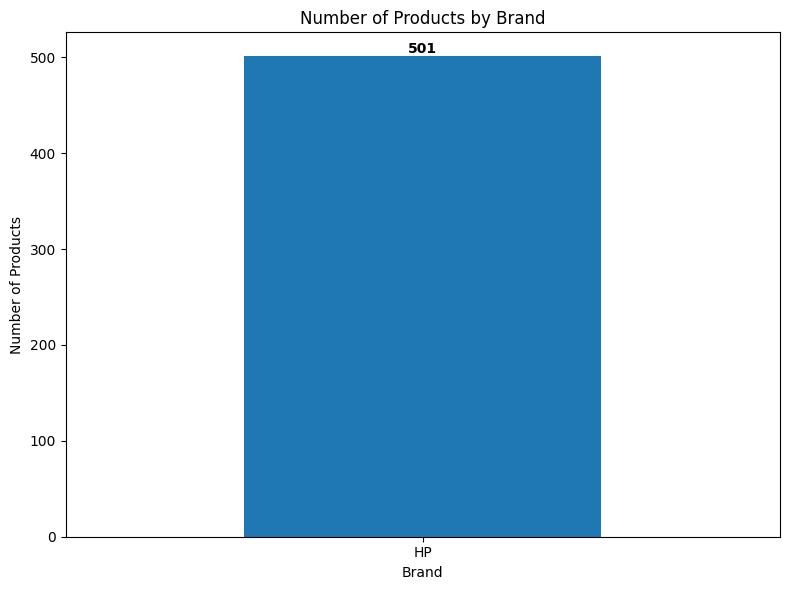

In [5]:
# brands = ['Apple', 'Samsung', 'Dell', 'HP']
brands = ['HP']
brand_counts = brand_counts[brands]

fig, ax = plt.subplots(figsize=(8, 6))
brand_counts.plot(kind='bar', ax=ax)

for i, v in enumerate(brand_counts):
    ax.text(i, v, str(v), color='black', fontweight='bold', horizontalalignment='center', verticalalignment='bottom')

plt.title('Number of Products by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Products')

plt.xticks(range(len(brands)), brands, rotation=0)

plt.tight_layout()
plt.show()

In [6]:
product_df = product_df[product_df['BrandName'].isin(brands)]
product_df

,SubCategoryID,ProductID,BrandName
174,29010,190725476,HP
175,29010,187188428,HP
176,29010,186984673,HP
177,29010,127377025,HP
178,29010,155530449,HP
...,...,...,...
1126,28900,27918571,HP
1146,2679,272909162,HP
1148,2679,272911011,HP
1159,12298,263394064,HP


In [9]:
product_df.to_csv("temp.csv", index=False)

### RETRIEVE PRODUCT DATA

In [ ]:
# filtered_df = pd.read_csv("data/product_id.csv")

In [7]:
product_data_list = []

for _, row in product_df.iterrows():
    sub_category_id = row['SubCategoryID']
    product_id = row['ProductID']

    URL = f"https://tiki.vn/api/v2/products/{product_id}"
    PARAMS = {}

    response = requests.get(URL, headers=HEADERS, params=PARAMS)
    time.sleep(random.uniform(3.2, 4.7))
    
    data = response.json()

    product_data = {
        'product_id': data['id'],
        'product_name': data.get('name', None),
        'product_url': data.get('short_url', None),
        'pricing_current': data.get('price', None),
        'pricing_original': data.get('original_price', None),
        'product_image_url': data.get('thumbnail_url', None),
        'inventory_status': data.get('inventory_status', None),
        'inventory_type': data.get('inventory_type', None),
        'created_date': data.get('day_ago_created', None),
        'quantity_sold': data.get('all_time_quantity_sold', None),
        'brand_id': data.get('brand', {}).get('id', None),
        'brand_name': data.get('brand', {}).get('name', None),
        'brand_slug': data.get('brand', {}).get('slug', None),
        'seller_id': data.get('current_seller', {}).get('id', 0) if data.get('current_seller') else 0,
        'seller_name': data.get('current_seller', {}).get('name', 0) if data.get('current_seller') else 0,
        'seller_link': data.get('current_seller', {}).get('link', 0) if data.get('current_seller') else 0,
        'seller_image_url': data.get('current_seller', {}).get('logo', 0) if data.get('current_seller') else 0,
        'category_id': data['categories']['id'] if data['categories']['is_leaf'] else data['breadcrumbs'][-2]['category_id'],
        'sub_category_id': sub_category_id,
        'brand_name': row['BrandName']
    }

    product_data_list.append(product_data)

print(f"Success fetching data for {len(product_data_list)} products")
product_df = pd.DataFrame(product_data_list, columns=['product_id', 'product_name', 'product_url', 'pricing_current', 'pricing_original', 'product_image_url', 'inventory_status', 'inventory_type', 'created_date', 'quantity_sold', 'brand_id', 'brand_name', 'brand_slug', 'seller_id', 'seller_name', 'seller_link', 'seller_image_url', 'category_id', 'sub_category_id', 'brand_name'])
product_df.to_csv("product_data_4.csv", index=False, encoding='utf-8-sig')
product_df.head(10)

Success fetching data for 501 products


,product_id,product_name,product_url,pricing_current,pricing_original,product_image_url,inventory_status,inventory_type,created_date,quantity_sold,brand_id,brand_name,brand_slug,seller_id,seller_name,seller_link,seller_image_url,category_id,sub_category_id,brand_name
0,190725476,Laptop HP Pavilion 15 eg2066TU i7 1260P/16GB/5...,https://tiki.vn/product-p190725476.html?spid=1...,28747200,28747200,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,663,2.0,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
1,187188428,Laptop HP ProBook 430 G8(614K6PA)(i3-1115G4|4...,https://tiki.vn/product-p187188428.html?spid=1...,21396000,21396000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,686,1.0,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
2,186984673,Laptop HP ProBook 430 G8 614K7PA)(i3-1115G4|8G...,https://tiki.vn/product-p186984673.html?spid=1...,23844000,23844000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,686,1.0,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
3,127377025,Laptop HP 15s-du1105TU 2Z6L3PA i3-10110U/4GB/2...,https://tiki.vn/product-p127377025.html?spid=1...,10945200,10945200,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,946,NaN,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
4,155530449,Laptop HP Envy x360 Convert 13 ay1057AU R5 560...,https://tiki.vn/product-p155530449.html?spid=1...,36204000,36204000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,852,NaN,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
5,151839086,Laptop HP Envy 13 ba1535TU i7 1165G7/8GB/512GB...,https://tiki.vn/product-p151839086.html?spid=1...,40020000,40020000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,867,NaN,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
6,180396187,Laptop HP Envy 13 ba1537TU i5 1135G7/8GB/256GB...,https://tiki.vn/product-p180396187.html?spid=1...,24000000,24000000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,716,NaN,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
7,163871476,Laptop HP Envy 13 ba1536TU i5 1135G7/8GB/512GB...,https://tiki.vn/product-p163871476.html?spid=1...,32772000,32772000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,806,1.0,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
8,180396111,"Laptop HP 340s G7 i5 1035G1/8GB/512GB/14""F/Win...",https://tiki.vn/product-p180396111.html?spid=1...,16190000,16190000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,711,NaN,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP
9,135268243,Laptop HP 340s G7 36A43PA (Core i5-1035G1/ 8GB...,https://tiki.vn/product-p135268243.html?spid=1...,22800000,22800000,https://salt.tikicdn.com/cache/280x280/ts/prod...,available,backorder,921,NaN,17825,HP,hp,282372,HP Flagship Ben Computer Store,https://tiki.vn/cua-hang/hp-flagship-ben-compu...,5d/df/39/075ce2285dc56968cd763aa7a3b9cf9a.jpg,29010,29010,HP


### RETRIEVE FEEDBACK DATA

In [9]:
feedback_data_list = []

for _, row in product_df.iterrows():
    sub_category_id = row['sub_category_id']
    product_id = row['product_id']
    URL = "https://tiki.vn/api/v2/reviews"
    PARAMS = {"limit": 20, "spid": sub_category_id, "product_id": product_id}

    # Get the total number of pages
    response = requests.get(URL, headers=HEADERS, params=PARAMS)
    data = response.json()
    total_pages = data.get("paging", {}).get("last_page", 1)

    # Fetch data from each page
    for page in range(1, total_pages + 1):
        PARAMS["page"] = page
        response = requests.get(URL, headers=HEADERS, params=PARAMS)
        time.sleep(random.uniform(3.2, 4.7))
        data = response.json()

        stars = data.get("stars", {})
        OneStarCount = stars.get("1", {}).get("count", 0)
        TwoStarCount = stars.get("2", {}).get("count", 0)
        ThreeStarCount = stars.get("3", {}).get("count", 0)
        FourStarCount = stars.get("4", {}).get("count", 0)
        FiveStarCount = stars.get("5", {}).get("count", 0)
        reviews_count = data.get("reviews_count", 0)
        review_data = data.get("data", [])

        for review in review_data:
            review_id = review.get("id")
            review_title = review.get("title")
            review_content = review.get("content")
            review_upvote = review.get("thank_count", 0)
            review_rating = review.get("rating")
            review_created_at = review.get("created_at")
            reviewer = review.get("created_by", {})

            if reviewer is not None:
                user_id = reviewer.get("id")
                username = reviewer.get("name")
                joined_time = reviewer.get("created_time")
                total_reviews = reviewer.get("contribute_info", {}).get("summary", {}).get("total_review", 0)
                total_upvotes = reviewer.get("contribute_info", {}).get("summary", {}).get("total_thank", 0)
            else:
                user_id = None
                username = None
                joined_time = None
                total_reviews = 0
                total_upvotes = 0

            feedback_data_list.append([OneStarCount, TwoStarCount, ThreeStarCount, FourStarCount, FiveStarCount,
                                       reviews_count, review_id, review_title, review_content, review_upvote,
                                       review_rating, review_created_at, user_id, username, joined_time,
                                       total_reviews, total_upvotes])

    print(f"Success fetching data for {len(feedback_data_list)} feedbacks")

feedback_df = pd.DataFrame(feedback_data_list, columns=["OneStarCount", "TwoStarCount", "ThreeStarCount", "FourStarCount",
                                                        "FiveStarCount", "reviews_count", "review_id", "review_title",
                                                        "review_content", "review_upvote", "review_rating",
                                                        "review_created_at", "user_id", "username", "joined_time",
                                                        "total_reviews", "total_upvotes"])

feedback_df.to_csv("feedback_data_4.csv", index=False, encoding='utf-8-sig')
feedback_df.head(10)

Success fetching data for 0 feedbacks
Success fetching data for 1 feedbacks
Success fetching data for 1 feedbacks
Success fetching data for 54 feedbacks
Success fetching data for 54 feedbacks
Success fetching data for 54 feedbacks
Success fetching data for 56 feedbacks
Success fetching data for 58 feedbacks
Success fetching data for 58 feedbacks
Success fetching data for 69 feedbacks
Success fetching data for 69 feedbacks
Success fetching data for 73 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 74 feedbacks
Success fetching data for 75 feedbacks
Success fetching data for 75 feedbacks
Success fetching data for 75 feedbacks
Success fetching data for 75 feedbacks
Success fetching data for 75

,OneStarCount,TwoStarCount,ThreeStarCount,FourStarCount,FiveStarCount,reviews_count,review_id,review_title,review_content,review_upvote,review_rating,review_created_at,user_id,username,joined_time,total_reviews,total_upvotes
0,0,0,0,0,1,1,17849683,Cực kì hài lòng,,0,5,1664688204,15351195.0,Tàng Thủy,2019-12-08 14:17:42,26,3
1,0,1,1,7,44,53,13866029,Cực kì hài lòng,giao hàng nhanh. máy đã cài sẵn win 11. mà cài...,3,5,1639634864,785327.0,Nguyễn Thị Mỹ Hậu,2015-08-31 08:29:46,26,33
2,0,1,1,7,44,53,15639461,Hài lòng,Giá bán trên tiki có vẻ cao. thấy chỗ khác máy...,1,3,1648439305,5682558.0,Than Thanh Thuy,2017-09-04 23:45:10,6,1
3,0,1,1,7,44,53,14351663,Cực kì hài lòng,"Giao hàng nhanh chóng, đóng gói rất cẩn thận, ...",0,5,1641738292,8743123.0,Lê Thị Tuyết Thu,2018-11-03 14:03:05,282,58
4,0,1,1,7,44,53,14031170,Cực kì hài lòng,"Tiki đóng gói rất cẩn thận, giao hàng nhanh, s...",0,5,1640273255,7065961.0,Trần Ngọc Minh Anh,2018-05-06 22:38:51,37,2
5,0,1,1,7,44,53,13771653,Cực kì hài lòng,"Laptop đẹp, chạy windows 11, Tiki giao hàng nh...",0,5,1639299905,1081277.0,Đỗ Xuân Thắng,2015-12-28 13:47:16,26,10
6,0,1,1,7,44,53,16717202,Cực kì hài lòng,Shop giao hang nhu hinh. Chat luong san pham t...,0,5,1655266543,10433155.0,NGUYEN MANH TUAN,2019-01-18 16:19:26,10,2
7,0,1,1,7,44,53,15335047,Cực kì hài lòng,"Máy trông cũng được, màn hình hơi to, nhưng ch...",1,5,1646821387,7742464.0,Jun,2018-08-24 10:20:47,17,2
8,0,1,1,7,44,53,15237794,Cực kì hài lòng,Hàng đúng nhu mô tả!!! Tiếc là hết hàng! còn m...,0,5,1646296943,19646158.0,Quốc Hoàng,2020-12-23 20:32:26,33,5
9,0,1,1,7,44,53,13905196,Cực kì hài lòng,"okokokokokokokokokokokokok sp rất ok, giá tốt",0,5,1639792916,13073524.0,Nguyễn Thành Luân,2019-07-25 09:39:35,105,4
